<a href="https://colab.research.google.com/github/caiumoua8/Math-120-Final-Project/blob/main/CAIU_MOUA_FINAL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----------------------------
##Introduction: Caiu Moua



Text being analyzed: Blonde by Frank Ocean



----------------------------------------------------------------
##Importing From Git Hub and Seperating the Text

In [1]:
import os
import sys
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import matplotlib.pyplot as plt

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")

    # Clone repository if in Colab
    if not os.path.exists('/content/Math-120-Final-Project'):
        !git clone https://github.com/caiumoua8/Math-120-Final-Project

    # Change to project directory
    os.chdir('/content/Math-120-Final-Project')

except ImportError:
    IN_COLAB = False
    print("Running locally")

# Add src directory to Python path
if 'src' not in sys.path:
    sys.path.append('src')

print(f"Current working directory: {os.getcwd()}")

Running in Google Colab
Current working directory: /content/Math-120-Final-Project


In [2]:
PATH = '/content/Math-120-Final-Project/raw_data/'

In [3]:
with open(PATH + "Frank.txt", "r") as f:
    raw_lines = [line.strip() for line in f.readlines() if line.strip() != ""]


In [4]:
raw_lines

['These bitches want Nikes',
 'They looking for a check',
 "Tell 'em it ain't likely",
 'Said she need a ring like Carmelo',
 'You must be on that white like Othello',
 'All you want is Nikes, but the real ones',
 'Just like you, just like me',
 "I don't play, I don't make time",
 'But if you need dick, I got you',
 'And I yam from the line',
 'Pour up for A$AP, R.I.P. Pimp C',
 'R.I.P. Trayvon, that nigga look just like me',
 "Woo, fuckin' buzzin', woo",
 'That my little cousin, he got a little trade',
 'His girl keep the scales, a little mermaid',
 'We out by the pool, some little mermaids',
 'Me and them gel like twigs with them bangs',
 "Now that's a real mermaid",
 'You been holding your breath, weighted down',
 'Punk madre, punk papá',
 "He don't care for me, but he cares for me",
 "And that's good enough",
 "We don't talk much or nothin'",
 "But when we talkin' 'bout somethin'",
 'We have good discussion',
 'I met his friends last week',
 "Feels like they're up to somethin'",
 "

---------------------------------------
##Tracking WHOLE Album Sentiments based on Postive/Negative/Neutral



In [5]:
import plotly.express as px
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Ensure vader_lexicon is downloaded
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

line_numbers = list(range(1, len(raw_lines) + 1))
sentiment_scores = []
for line in raw_lines:
    score = sia.polarity_scores(line)["compound"]
    sentiment_scores.append(score)

sent_df = pd.DataFrame({
    "line_number": line_numbers,
    "line": raw_lines,
    "sentiment": sentiment_scores
})
sent_df["rolling_sentiment"] = sent_df["sentiment"].rolling(window=5, center=True).mean()

fig = px.line(
    sent_df,
    x="line_number",
    y="rolling_sentiment",
    title="Smoothed Sentiment (Rolling Avg Window=5)"
)

song_starts1 = [60,109,158,183,242,272,314,331,425,459,479,522,591,611,750]

song_titles = [
    "Nikes", "Ivy", "Pink + White", "Be Yourself", "Solo", 'Skyline To', 'Self Control', 'Good Guy', 'Nights', 'Pretty Sweet', 'Facebook Story', 'White Ferrari', 'Seigfried', 'Godspeed', 'Futura Free'
]

for start, title in zip(song_starts1, song_titles):
    fig.add_vline(
        x=start,
        line_dash="dash",
        line_color="black",
        opacity=0.5
    )
    fig.add_annotation(
        x=start,
        y=max(sent_df["rolling_sentiment"]),  # place label at top
        text=title,
        showarrow=False,
        xshift=-5,
        textangle=90,
        yshift=105,
        font=dict(size=10)
    )
fig.update_yaxes(range=[-1, 1])
fig.show()


------------------------------------------------------
##Tracking Sentiments based on EMOTIONS

In [6]:
model_name = "j-hartmann/emotion-english-distilroberta-base"
labels = ['anger','disgust','fear','joy','sadness','surprise']

# Load tokenizer + model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def get_emotions(text):
    inputs = tokenizer(text,
                       return_tensors="pt",
                       truncation=True,
                       padding=True,
                       max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]

    return dict(zip(labels, probs))

emotion_lines = [get_emotions(line) for line in raw_lines]

df = pd.DataFrame(emotion_lines)
df["line"] = range(1, len(df) + 1)




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



In [7]:
print(df)

        anger   disgust      fear       joy   sadness  surprise  line
0    0.091611  0.080753  0.003166  0.013358  0.737727  0.028939     1
1    0.020370  0.008189  0.024539  0.007558  0.801120  0.068265     2
2    0.035383  0.026473  0.022804  0.017283  0.763031  0.071927     3
3    0.020335  0.006640  0.015048  0.017228  0.663768  0.059378     4
4    0.004543  0.005116  0.002455  0.004746  0.909123  0.009481     5
..        ...       ...       ...       ...       ...       ...   ...
748  0.090044  0.104462  0.005997  0.017808  0.768844  0.010153   749
749  0.002282  0.001971  0.001212  0.973460  0.002720  0.016569   750
750  0.259437  0.036684  0.036662  0.031321  0.579465  0.015546   751
751  0.011886  0.013596  0.007748  0.002978  0.847035  0.007554   752
752  0.009478  0.004291  0.007208  0.215252  0.498548  0.009658   753

[753 rows x 7 columns]


In [8]:
song_emotion_avg = df[["anger","disgust","fear","joy","sadness","surprise"]].mean()

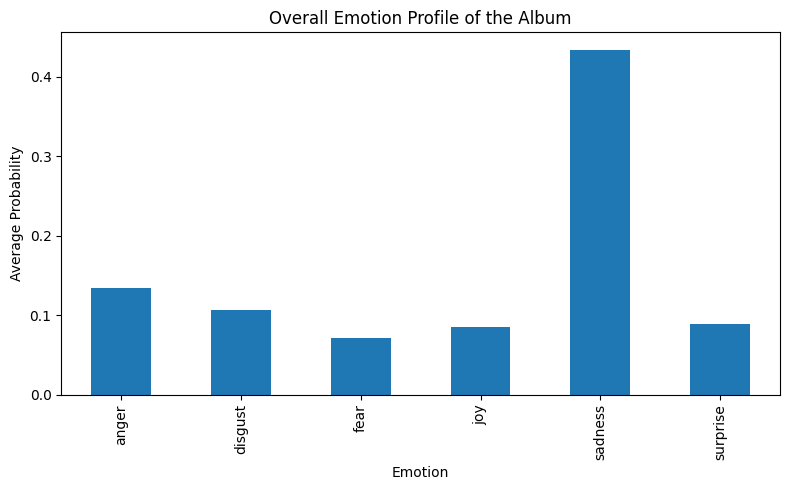

In [9]:
emotion_columns = ["anger","disgust","fear","joy","sadness","surprise"]
album_emotions = df[emotion_columns].mean()

plt.figure(figsize=(8,5))
album_emotions.plot(kind="bar")
plt.title("Overall Emotion Profile of the Album")
plt.ylabel("Average Probability")
plt.xlabel("Emotion")
plt.tight_layout()
plt.show()


---------------------------------------------------------------
##Tracking EMOTIONS Song to Song

In [10]:
song_starts1_adjusted = [s - 1 for s in song_starts1]
songs = []
current_song_idx = 0
for i in range(len(raw_lines)):
    if current_song_idx + 1 < len(song_starts1_adjusted) and i >= song_starts1_adjusted[current_song_idx + 1]:
        current_song_idx += 1
    songs.append(song_titles[current_song_idx])

df["song"] = songs

emotion_cols = labels
song_emotions = df.groupby("song")[emotion_cols].mean()
top_emotions = song_emotions.idxmax(axis=1)
top_values = song_emotions.max(axis=1)
summary_table = pd.DataFrame({
    "Top Emotion": top_emotions,
    "Percentage": top_values
}).reset_index()

summary_table.columns = ["Song", "Top Emotion", "Percentage"]

album_order = song_titles
summary_table['Song'] = pd.Categorical(summary_table['Song'], categories=album_order, ordered=True)
summary_table_ordered = summary_table.sort_values('Song').reset_index(drop=True)
display(summary_table_ordered)

,Song,Top Emotion,Percentage
0,Nikes,sadness,0.437306
1,Ivy,sadness,0.539266
2,Pink + White,sadness,0.511114
3,Be Yourself,sadness,0.429686
4,Solo,sadness,0.380801
5,Skyline To,sadness,0.485433
6,Self Control,sadness,0.334061
7,Good Guy,sadness,0.381999
8,Nights,sadness,0.513963
9,Pretty Sweet,sadness,0.369485


In [11]:
second_top_emotions = song_emotions.apply(lambda x: x.nlargest(2).index[1], axis=1)
second_top_values = song_emotions.apply(lambda x: x.nlargest(2).iloc[1], axis=1)

second_summary_table = pd.DataFrame({
    "Song": second_top_emotions.index,
    "Second Top Emotion": second_top_emotions,
    "Percentage": second_top_values
}).reset_index(drop=True)

album_order = song_titles
second_summary_table['Song'] = pd.Categorical(second_summary_table['Song'], categories=album_order, ordered=True)
second_summary_table_ordered = second_summary_table.sort_values('Song').reset_index(drop=True)
display(second_summary_table_ordered)

,Song,Second Top Emotion,Percentage
0,Nikes,disgust,0.114091
1,Ivy,surprise,0.098540
2,Pink + White,disgust,0.218714
3,Be Yourself,anger,0.145527
4,Solo,disgust,0.139707
5,Skyline To,surprise,0.108936
6,Self Control,anger,0.196816
7,Good Guy,anger,0.190164
8,Nights,anger,0.128754
9,Pretty Sweet,anger,0.192965
